In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"urja2007","key":"0b43659003cd96e7f480e7504df8a523"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d apollo2506/eurosat-dataset

Dataset URL: https://www.kaggle.com/datasets/apollo2506/eurosat-dataset
License(s): CC0-1.0
100% 2.04G/2.04G [00:30<00:00, 47.9MB/s]
100% 2.04G/2.04G [00:31<00:00, 70.0MB/s]


In [4]:
!unzip eurosat-dataset.zip -d eurosat_data

Streaming output truncated to the last 5000 lines.
  inflating: eurosat_data/EuroSATallBands/River/River_1990.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_1991.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_1992.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_1993.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_1994.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_1995.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_1996.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_1997.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_1998.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_1999.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_2.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_20.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_200.tif  
  inflating: eurosat_data/EuroSATallBands/River/River_2000.tif  
  inflating: eurosat_data/EuroSATallBands/Riv

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import os
import time
import json
from tqdm import tqdm
import warnings
import rasterio # Import rasterio for reading .tif files
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================================================
# CONFIGURATION
# ============================================================================
# Plan 1, 2, 3, or 4
HIERARCHICAL_PLAN = 1

# EuroSAT class names
CLASS_NAMES = [
    'AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway',
    'Industrial', 'Pasture', 'PermanentCrop', 'Residential',
    'River', 'SeaLake'
]

# Define hierarchical structures for different plans
HIERARCHIES = {
    1: {
        'Superclass 0': ['SeaLake'],
        'Superclass 1': ['River', 'Industrial'],
        'Superclass 2': ['Highway', 'Residential', 'AnnualCrop',
                        'PermanentCrop', 'HerbaceousVegetation',
                        'Pasture', 'Forest']
    },
    2: {
        'Superclass 0': ['SeaLake'],
        'Superclass 1': ['River', 'Industrial'],
        'Superclass 2': ['Highway', 'Residential', 'AnnualCrop',
                        'PermanentCrop', 'HerbaceousVegetation'],
        'Superclass 3': ['Pasture', 'Forest']
    },
    3: {
        'Superclass 0': ['SeaLake'],
        'Superclass 1': ['River', 'Industrial'],
        'Superclass 2': ['Highway', 'Residential'],
        'Superclass 3': ['AnnualCrop', 'PermanentCrop',
                        'HerbaceousVegetation'],
        'Superclass 4': ['Pasture', 'Forest']
    },
    4: {
        'Superclass 0': ['SeaLake'],
        'Superclass 1': ['River', 'Industrial'],
        'Superclass 2': {
            'group1': ['Highway', 'Residential'],
            'group2': ['AnnualCrop', 'PermanentCrop', 'HerbaceousVegetation']
        },
        'Superclass 3': ['Pasture', 'Forest']
    }
}

# Select current hierarchy
hierarchy = HIERARCHIES[HIERARCHICAL_PLAN]
print(f"Using Hierarchical Plan {HIERARCHICAL_PLAN}")
print("Hierarchy Structure:")
for superclass, classes in hierarchy.items():
    print(f"  {superclass}: {classes}")

# ============================================================================
# CUSTOM DATASET FOR EUROSAT (13 BANDS)
# ============================================================================
class EuroSAT13Bands(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = CLASS_NAMES
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        self.images = []
        self.labels = []

        # Load all images
        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            if os.path.exists(class_path):
                for img_name in os.listdir(class_path):
                    # Change condition to look for .tif files
                    if img_name.endswith('.tif'):
                        img_path = os.path.join(class_path, img_name)
                        self.images.append(img_path)
                        self.labels.append(self.class_to_idx[class_name])

        print(f"Loaded {len(self.images)} images from {len(self.classes)} classes")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load 13-channel image (.tif) using rasterio
        img_path = self.images[idx]
        with rasterio.open(img_path) as src:
            img_array = src.read() # Reads as (bands, height, width)

        # Normalize each channel (img_array is (bands, height, width))
        # Ensure normalization happens per channel across spatial dimensions
        img_array_normalized = np.zeros_like(img_array, dtype=np.float32)
        for i in range(img_array.shape[0]):
            channel_data = img_array[i]
            min_val = channel_data.min()
            max_val = channel_data.max()
            if (max_val - min_val) > 1e-8:
                img_array_normalized[i] = (channel_data - min_val) / (max_val - min_val);
            else:
                img_array_normalized[i] = 0.0 # Handle case where channel is constant

        # Convert to tensor (rasterio already reads as (C, H, W))
        img_tensor = torch.FloatTensor(img_array_normalized) # [13, 64, 64]

        label = self.labels[idx]

        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, label

# ============================================================================
# MODEL ARCHITECTURE - Modified ResNet18 for 13 channels
# ============================================================================
class ModifiedResNet18(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(ModifiedResNet18, self).__init__()

        # Load pretrained ResNet18
        if pretrained:
            weights = ResNet18_Weights.IMAGENET1K_V1
            self.resnet = resnet18(weights=weights)
        else:
            self.resnet = resnet18()

        # Modify first conv layer to accept 13 channels instead of 3
        original_conv1 = self.resnet.conv1
        self.resnet.conv1 = nn.Conv2d(
            13, 64, kernel_size=7, stride=2, padding=3, bias=False
        )

        # Initialize new conv layer weights
        if pretrained:
            # Copy weights from first 3 channels and average for remaining
            with torch.no_grad():
                self.resnet.conv1.weight[:, :3] = original_conv1.weight
                for i in range(3, 13):
                    self.resnet.conv1.weight[:, i] = original_conv1.weight.mean(dim=1)

        # Modify final layer for our number of classes
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

# ============================================================================
# TRAINING AND EVALUATION FUNCTIONS
# ============================================================================
class HierarchicalClassifier:
    def __init__(self, hierarchy, class_names):
        self.hierarchy = hierarchy
        self.class_names = class_names
        self.superclass_models = {}
        self.fine_models = {}
        self.superclass_mappings = {}
        self.fine_mappings = {}

        # Create mappings
        self._create_mappings()

    def _create_mappings(self):
        """Create mappings between original classes and hierarchical classes"""
        # Superclass mapping
        for superclass_name, classes in self.hierarchy.items():
            superclass_idx = list(self.hierarchy.keys()).index(superclass_name)

            if isinstance(classes, dict):  # For Plan 4 with subgroups
                all_classes = []
                for subgroup in classes.values():
                    all_classes.extend(subgroup)
                classes = all_classes

            for class_name in classes:
                original_idx = self.class_names.index(class_name)
                self.superclass_mappings[original_idx] = superclass_idx

            # Fine-grained mapping within superclass
            if len(classes) > 1:  # Only create fine mapping if multiple classes
                fine_mapping = {}
                for fine_idx, class_name in enumerate(classes):
                    original_idx = self.class_names.index(class_name)
                    fine_mapping[original_idx] = fine_idx
                self.fine_mappings[superclass_idx] = fine_mapping

    def get_superclass_label(self, original_label):
        return self.superclass_mappings.get(original_label, -1)

    def get_fine_label(self, original_label, superclass_label):
        if superclass_label in self.fine_mappings:
            return self.fine_mappings[superclass_label].get(original_label, -1)
        return -1

    def train_superclass_classifier(self, train_loader, val_loader, superclass_name,
                                   num_epochs=50, lr=0.001, model_save_path=None):
        """
        Train a superclass classifier
        """
        print(f"\n{'='*60}")
        print(f"TRAINING SUPERCLASS CLASSIFIER: {superclass_name}")
        print(f"{'='*60}")

        # Get number of superclasses
        num_superclasses = len(self.hierarchy)

        # Initialize model
        model = ModifiedResNet18(num_classes=num_superclasses).to(device)

        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                        patience=5, factor=0.5)

        # Training history
        history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': []
        }

        best_val_acc = 0
        best_model_state = None

        # Training loop
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0

            pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
            for images, labels in pbar:
                images = images.to(device)

                # Convert original labels to superclass labels
                superclass_labels = []
                for label in labels:
                    superclass_label = self.get_superclass_label(label.item())
                    superclass_labels.append(superclass_label)

                superclass_labels = torch.tensor(superclass_labels, dtype=torch.long).to(device)

                # Filter out invalid labels (-1)
                valid_indices = (superclass_labels != -1)
                if not valid_indices.any():
                    continue

                images = images[valid_indices]
                superclass_labels = superclass_labels[valid_indices]

                # Forward pass
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, superclass_labels)

                # Backward pass
                loss.backward()
                optimizer.step()

                # Statistics
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                train_total += superclass_labels.size(0)
                train_correct += predicted.eq(superclass_labels).sum().item()

                pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{100.*train_correct/max(1, train_total):.2f}%'
                })

            avg_train_loss = train_loss / max(1, len(train_loader))
            train_acc = 100. * train_correct / max(1, train_total)

            # Validation phase
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for images, labels in val_loader:
                    images = images.to(device)

                    # Convert labels
                    superclass_labels = []
                    for label in labels:
                        superclass_label = self.get_superclass_label(label.item())
                        superclass_labels.append(superclass_label)

                    superclass_labels = torch.tensor(superclass_labels, dtype=torch.long).to(device)

                    valid_indices = (superclass_labels != -1)
                    if not valid_indices.any():
                        continue

                    images = images[valid_indices]
                    superclass_labels = superclass_labels[valid_indices]

                    outputs = model(images)
                    loss = criterion(outputs, superclass_labels)

                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    val_total += superclass_labels.size(0)
                    val_correct += predicted.eq(superclass_labels).sum().item()

            avg_val_loss = val_loss / max(1, len(val_loader))
            val_acc = 100. * val_correct / max(1, val_total)

            # Update learning rate
            scheduler.step(avg_val_loss)

            # Save history
            history['train_loss'].append(avg_train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(avg_val_loss)
            history['val_acc'].append(val_acc)

            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict().copy()

            print(f'Epoch {epoch+1}: '
                  f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | '
                  f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # Load best model
        if best_model_state:
            model.load_state_dict(best_model_state)

        # Save model
        if model_save_path:
            torch.save({
                'model_state_dict': model.state_dict(),
                'hierarchy': self.hierarchy,
                'class_names': self.class_names,
                'mappings': self.superclass_mappings
            }, model_save_path)
            print(f"Model saved to {model_save_path}")

        # Plot training history
        self.plot_training_history(history, superclass_name)

        # Evaluate on validation set
        self.evaluate_superclass(model, val_loader, superclass_name)

        return model, history

    def train_fine_classifier(self, train_loader, val_loader, superclass_idx,
                             superclass_name, num_epochs=30, lr=0.001,
                             model_save_path=None):
        """
        Train a fine-grained classifier for a specific superclass
        """
        print(f"\n{'='*60}")
        print(f"TRAINING FINE-GRAINED CLASSIFIER FOR: {superclass_name}")
        print(f"{'='*60}")

        # Get number of fine classes in this superclass
        classes = self.hierarchy[superclass_name]
        if isinstance(classes, dict):
            all_classes = []
            for subgroup in classes.values():
                all_classes.extend(subgroup)
            num_fine_classes = len(all_classes)
        else:
            num_fine_classes = len(classes)

        print(f"Number of fine classes: {num_fine_classes}")

        if num_fine_classes <= 1:
            print("Only one class in this superclass. Skipping fine-grained training.")
            return None, None

        # Initialize model
        model = ModifiedResNet18(num_classes=num_fine_classes).to(device)

        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                        patience=5, factor=0.5)

        # Training history
        history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': []
        }

        best_val_acc = 0
        best_model_state = None

        # Training loop
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0

            pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device) # Move images and labels to device

                # Filter images belonging to this superclass
                superclass_labels_tensor = []
                for label in labels:
                    superclass_label = self.get_superclass_label(label.item())
                    superclass_labels_tensor.append(superclass_label)

                superclass_labels_tensor = torch.tensor(superclass_labels_tensor).to(device)

                # Only keep images from this superclass
                indices = (superclass_labels_tensor == superclass_idx)
                if not indices.any():
                    continue

                images = images[indices]
                original_labels = labels[indices]

                # Convert to fine labels
                fine_labels = []
                for label in original_labels:
                    fine_label = self.get_fine_label(label.item(), superclass_idx)
                    fine_labels.append(fine_label)

                fine_labels = torch.tensor(fine_labels, dtype=torch.long).to(device)

                # Forward pass
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, fine_labels)

                # Backward pass
                loss.backward()
                optimizer.step()

                # Statistics
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                train_total += fine_labels.size(0)
                train_correct += predicted.eq(fine_labels).sum().item()

                pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{100.*train_correct/max(1, train_total):.2f}%'
                })

            avg_train_loss = train_loss / max(1, len(train_loader))
            train_acc = 100. * train_correct / max(1, train_total)

            # Validation phase
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device) # Move images and labels to device

                    # Filter images
                    superclass_labels_tensor = []
                    for label in labels:
                        superclass_label = self.get_superclass_label(label.item())
                        superclass_labels_tensor.append(superclass_label)

                    superclass_labels_tensor = torch.tensor(superclass_labels_tensor).to(device)

                    indices = (superclass_labels_tensor == superclass_idx)
                    if not indices.any():
                        continue

                    images = images[indices]
                    original_labels = labels[indices]

                    # Convert to fine labels
                    fine_labels = []
                    for label in original_labels:
                        fine_label = self.get_fine_label(label.item(), superclass_idx)
                        fine_labels.append(fine_label)

                    fine_labels = torch.tensor(fine_labels, dtype=torch.long).to(device)

                    outputs = model(images)
                    loss = criterion(outputs, fine_labels)

                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    val_total += fine_labels.size(0)
                    val_correct += predicted.eq(fine_labels).sum().item()

            avg_val_loss = val_loss / max(1, len(val_loader))
            val_acc = 100. * val_correct / max(1, val_total)

            # Update learning rate
            scheduler.step(avg_val_loss)

            # Save history
            history['train_loss'].append(avg_train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(avg_val_loss)
            history['val_acc'].append(val_acc)

            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict().copy()

            print(f'Epoch {epoch+1}: '
                  f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | '
                  f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        # Load best model
        if best_model_state:
            model.load_state_dict(best_model_state)

        # Save model
        if model_save_path:
            torch.save({
                'model_state_dict': model.state_dict(),
                'superclass_idx': superclass_idx,
                'superclass_name': superclass_name,
                'num_classes': num_fine_classes
            }, model_save_path)
            print(f"Model saved to {model_save_path}")

        # Plot training history
        self.plot_training_history(history, f"{superclass_name}_fine")

        # Evaluate
        self.evaluate_fine_classifier(model, val_loader, superclass_idx, superclass_name)

        return model, history

    def plot_training_history(self, history, title):
        """Plot training and validation loss/accuracy"""
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Loss plot
        axes[0].plot(history['train_loss'], label='Train Loss')
        axes[0].plot(history['val_loss'], label='Val Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title(f'{title} - Loss')
        axes[0].legend()
        axes[0].grid(True)

        # Accuracy plot
        axes[1].plot(history['train_acc'], label='Train Acc')
        axes[1].plot(history['val_acc'], label='Val Acc')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy (%)')
        axes[1].set_title(f'{title} - Accuracy')
        axes[1].legend()
        axes[1].grid(True)

        plt.tight_layout()
        plt.show()

    def evaluate_superclass(self, model, val_loader, superclass_name):
        """Evaluate superclass classifier"""
        print(f"\nEvaluating {superclass_name} classifier...")

        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)

                # Convert to superclass labels
                superclass_labels = []
                for label in labels:
                    superclass_label = self.get_superclass_label(label.item())
                    superclass_labels.append(superclass_label)

                superclass_labels = torch.tensor(superclass_labels, dtype=torch.long).to(device)

                valid_indices = (superclass_labels != -1)
                if not valid_indices.any():
                    continue

                images = images[valid_indices]
                superclass_labels = superclass_labels[valid_indices]

                outputs = model(images)
                _, preds = outputs.max(1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(superclass_labels.cpu().numpy())

        if len(all_labels) > 0:
            # Calculate metrics
            accuracy = accuracy_score(all_labels, all_preds)
            f1 = f1_score(all_labels, all_preds, average='weighted')

            print(f"Superclass Accuracy: {accuracy:.4f}")
            print(f"Superclass F1 Score: {f1:.4f}")

            # Confusion matrix
            self.plot_confusion_matrix(all_labels, all_preds,
                                      range(len(self.hierarchy)),
                                      f"Confusion Matrix - {superclass_name}")

            return accuracy, f1
        else:
            print("No valid samples found for evaluation")
            return 0, 0

    def evaluate_fine_classifier(self, model, val_loader, superclass_idx, superclass_name):
        """Evaluate fine-grained classifier"""
        print(f"\nEvaluating fine-grained classifier for {superclass_name}...")

        model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device) # Move images and labels to device

                # Filter for this superclass
                superclass_labels_tensor = []
                for label in labels:
                    superclass_label = self.get_superclass_label(label.item())
                    superclass_labels_tensor.append(superclass_label)

                superclass_labels_tensor = torch.tensor(superclass_labels_tensor).to(device)

                indices = (superclass_labels_tensor == superclass_idx)
                if not indices.any():
                    continue

                images = images[indices]
                original_labels = labels[indices]

                # Convert to fine labels
                fine_labels = []
                for label in original_labels:
                    fine_label = self.get_fine_label(label.item(), superclass_idx)
                    fine_labels.append(fine_label)

                fine_labels = torch.tensor(fine_labels, dtype=torch.long).to(device)

                outputs = model(images)
                _, preds = outputs.max(1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(fine_labels.cpu().numpy())

        if len(all_labels) > 0:
            # Calculate metrics
            accuracy = accuracy_score(all_labels, all_preds)
            f1 = f1_score(all_labels, all_preds, average='weighted')

            print(f"Fine-grained Accuracy: {accuracy:.4f}")
            print(f"Fine-grained F1 Score: {f1:.4f}")

            # Get class names for this superclass
            classes = self.hierarchy[superclass_name]
            if isinstance(classes, dict):
                all_classes = []
                for subgroup in classes.values():
                    all_classes.extend(subgroup)
                class_names = all_classes
            else:
                class_names = classes

            # Confusion matrix
            self.plot_confusion_matrix(all_labels, all_preds,
                                      range(len(class_names)),
                                      f"Confusion Matrix - {superclass_name} Fine",
                                      class_names=class_names)

            return accuracy, f1
        else:
            print("No samples found for evaluation")
            return 0, 0

    def plot_confusion_matrix(self, y_true, y_pred, classes, title, class_names=None):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names if class_names else classes,
                   yticklabels=class_names if class_names else classes)
        plt.title(title)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

Using device: cuda
Using Hierarchical Plan 1
Hierarchy Structure:
  Superclass 0: ['SeaLake']
  Superclass 1: ['River', 'Industrial']
  Superclass 2: ['Highway', 'Residential', 'AnnualCrop', 'PermanentCrop', 'HerbaceousVegetation', 'Pasture', 'Forest']


In [6]:
# ============================================================================
# MAIN EXECUTION - SEPARATE CELLS FOR EACH SUPERCLASS
# ============================================================================

# CELL 1: Data Loading and Preparation
print("CELL 1: Loading and Preparing Data")
print("="*60)

# Path to your EuroSAT dataset
DATASET_PATH = "/content/eurosat_data/EuroSATallBands"
# Create dataset
transform = transforms.Compose([
    transforms.Normalize(mean=[0.5]*13, std=[0.5]*13)  # Simple normalization
])

dataset = EuroSAT13Bands(DATASET_PATH, transform=transform)

# Split dataset into train, validation, and test
indices = list(range(len(dataset)))
train_indices, temp_indices = train_test_split(indices, test_size=0.3, random_state=42, stratify=dataset.labels)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42, stratify=[dataset.labels[i] for i in temp_indices])

print(f"Total samples: {len(dataset)}")
print(f"Training samples: {len(train_indices)}")
print(f"Validation samples: {len(val_indices)}")
print(f"Test samples: {len(test_indices)}")

# Create data loaders
train_loader = DataLoader(
    Subset(dataset, train_indices),
    batch_size=32,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    Subset(dataset, val_indices),
    batch_size=32,
    shuffle=False,
    num_workers=2
)

test_loader = DataLoader(
    Subset(dataset, test_indices),
    batch_size=32,
    shuffle=False,
    num_workers=2
)

# Initialize hierarchical classifier
hierarchical_classifier = HierarchicalClassifier(hierarchy, CLASS_NAMES)

# Create directories for saving models
os.makedirs('models', exist_ok=True)

print("\nData loading complete. Ready for training.")
print("="*60)


CELL 1: Loading and Preparing Data
Loaded 27597 images from 10 classes
Total samples: 27597
Training samples: 19317
Validation samples: 4140
Test samples: 4140

Data loading complete. Ready for training.



CELL 2: Training Superclass Classifier

TRAINING SUPERCLASS CLASSIFIER: All_Superclasses


Epoch 1/15 [Train]: 100%|██████████| 604/604 [00:56<00:00, 10.66it/s, Loss=0.7158, Acc=91.32%]


Epoch 1: Train Loss: 0.2454, Train Acc: 91.32% | Val Loss: 0.2710, Val Acc: 90.34%


Epoch 2/15 [Train]: 100%|██████████| 604/604 [01:02<00:00,  9.74it/s, Loss=0.3355, Acc=94.89%]


Epoch 2: Train Loss: 0.1407, Train Acc: 94.89% | Val Loss: 0.1110, Val Acc: 96.79%


Epoch 3/15 [Train]: 100%|██████████| 604/604 [01:01<00:00,  9.82it/s, Loss=0.0611, Acc=96.22%]


Epoch 3: Train Loss: 0.1114, Train Acc: 96.22% | Val Loss: 0.0875, Val Acc: 97.25%


Epoch 4/15 [Train]: 100%|██████████| 604/604 [00:57<00:00, 10.54it/s, Loss=0.0711, Acc=96.87%]


Epoch 4: Train Loss: 0.0894, Train Acc: 96.87% | Val Loss: 0.2009, Val Acc: 92.39%


Epoch 5/15 [Train]: 100%|██████████| 604/604 [00:56<00:00, 10.70it/s, Loss=0.0179, Acc=97.54%]


Epoch 5: Train Loss: 0.0693, Train Acc: 97.54% | Val Loss: 0.1156, Val Acc: 97.34%


Epoch 6/15 [Train]: 100%|██████████| 604/604 [01:04<00:00,  9.31it/s, Loss=0.0254, Acc=97.62%]


Epoch 6: Train Loss: 0.0700, Train Acc: 97.62% | Val Loss: 0.1088, Val Acc: 96.81%


Epoch 7/15 [Train]: 100%|██████████| 604/604 [00:57<00:00, 10.53it/s, Loss=0.0016, Acc=98.04%]


Epoch 7: Train Loss: 0.0558, Train Acc: 98.04% | Val Loss: 0.0899, Val Acc: 97.20%


Epoch 8/15 [Train]: 100%|██████████| 604/604 [00:57<00:00, 10.50it/s, Loss=0.0044, Acc=98.69%]


Epoch 8: Train Loss: 0.0415, Train Acc: 98.69% | Val Loss: 0.0903, Val Acc: 97.61%


Epoch 9/15 [Train]: 100%|██████████| 604/604 [00:56<00:00, 10.69it/s, Loss=0.0044, Acc=98.64%]


Epoch 9: Train Loss: 0.0434, Train Acc: 98.64% | Val Loss: 0.1607, Val Acc: 94.88%


Epoch 10/15 [Train]: 100%|██████████| 604/604 [00:57<00:00, 10.55it/s, Loss=0.0021, Acc=99.59%]


Epoch 10: Train Loss: 0.0127, Train Acc: 99.59% | Val Loss: 0.0755, Val Acc: 97.85%


Epoch 11/15 [Train]: 100%|██████████| 604/604 [00:56<00:00, 10.70it/s, Loss=0.0028, Acc=99.60%]


Epoch 11: Train Loss: 0.0128, Train Acc: 99.60% | Val Loss: 0.0811, Val Acc: 97.90%


Epoch 12/15 [Train]: 100%|██████████| 604/604 [00:56<00:00, 10.67it/s, Loss=0.0032, Acc=99.66%]


Epoch 12: Train Loss: 0.0102, Train Acc: 99.66% | Val Loss: 0.0866, Val Acc: 97.87%


Epoch 13/15 [Train]: 100%|██████████| 604/604 [00:57<00:00, 10.43it/s, Loss=0.0284, Acc=99.76%]


Epoch 13: Train Loss: 0.0082, Train Acc: 99.76% | Val Loss: 0.0857, Val Acc: 97.92%


Epoch 14/15 [Train]: 100%|██████████| 604/604 [00:56<00:00, 10.67it/s, Loss=0.0003, Acc=99.49%]


Epoch 14: Train Loss: 0.0157, Train Acc: 99.49% | Val Loss: 0.0813, Val Acc: 98.00%


Epoch 15/15 [Train]: 100%|██████████| 604/604 [00:56<00:00, 10.69it/s, Loss=0.0004, Acc=99.78%]


Epoch 15: Train Loss: 0.0066, Train Acc: 99.78% | Val Loss: 0.0971, Val Acc: 97.39%
Model saved to models/superclass_classifier.pth


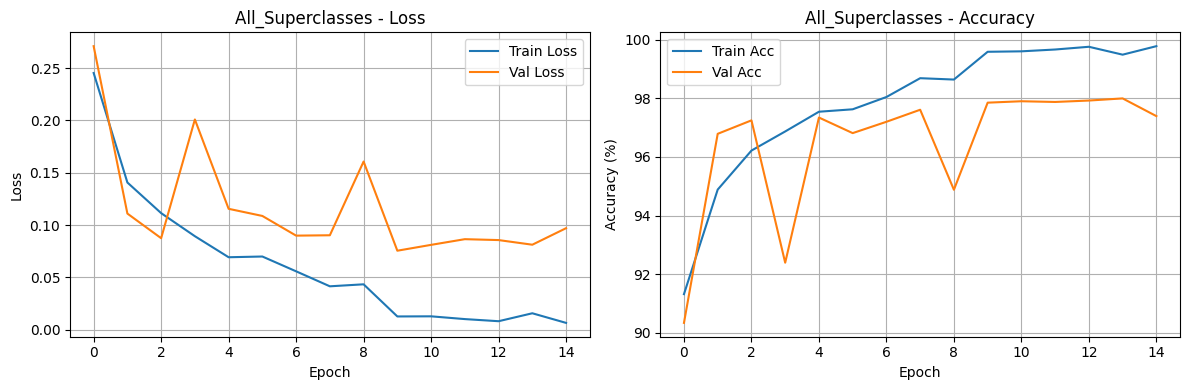


Evaluating All_Superclasses classifier...
Superclass Accuracy: 0.9739
Superclass F1 Score: 0.9741


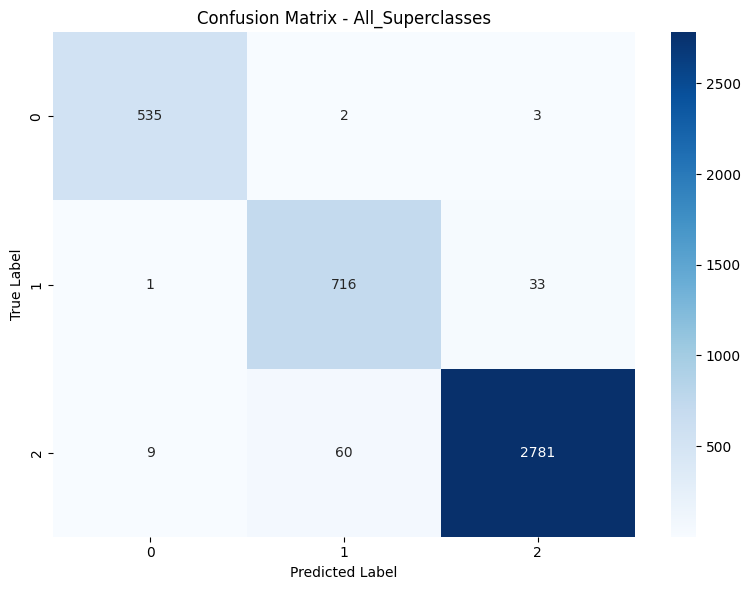

In [10]:
# CELL 2: Train Superclass Classifier
print("\nCELL 2: Training Superclass Classifier")
print("="*60)

# Train the superclass classifier (all superclasses together)
superclass_model, superclass_history = hierarchical_classifier.train_superclass_classifier(
    train_loader=train_loader,
    val_loader=val_loader,
    superclass_name="All_Superclasses",
    num_epochs=15,  # Reduced for testing, increase for full training
    lr=0.001,
    model_save_path="models/superclass_classifier.pth"
)

# Store the superclass model
hierarchical_classifier.superclass_models['all'] = superclass_model

In [7]:
# CELL 3: Train Fine-grained Classifier for Superclass 0
print("\nCELL 3: Training Fine-grained Classifier for Superclass 0")
print("="*60)

superclass_name = 'Superclass 0'
superclass_idx = 0

# Check if fine-grained training is needed
classes = hierarchy[superclass_name]
if isinstance(classes, dict):
    num_classes = sum(len(subgroup) for subgroup in classes.values())
else:
    num_classes = len(classes)

print(f"Superclass {superclass_idx} has {num_classes} classes")

if num_classes > 1:
    fine_model, fine_history = hierarchical_classifier.train_fine_classifier(
        train_loader=train_loader,
        val_loader=val_loader,
        superclass_idx=superclass_idx,
        superclass_name=superclass_name,
        num_epochs=15,  # Reduced for testing
        lr=0.001,
        model_save_path=f"models/fine_classifier_superclass_{superclass_idx}.pth"
    )
    if fine_model:
        hierarchical_classifier.fine_models[superclass_idx] = fine_model
else:
    print(f"Skipping fine-grained training for {superclass_name} - only one class")



CELL 3: Training Fine-grained Classifier for Superclass 0
Superclass 0 has 1 classes
Skipping fine-grained training for Superclass 0 - only one class



CELL 4: Training Fine-grained Classifier for Superclass 1
Superclass 1 has 2 classes

TRAINING FINE-GRAINED CLASSIFIER FOR: Superclass 1
Number of fine classes: 2
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]
Epoch 1/15 [Train]: 100%|██████████| 604/604 [00:57<00:00, 10.42it/s, Loss=0.0229, Acc=90.14%]


Epoch 1: Train Loss: 0.3294, Train Acc: 90.14% | Val Loss: 0.1767, Val Acc: 96.67%


Epoch 2/15 [Train]: 100%|██████████| 604/604 [00:57<00:00, 10.42it/s, Loss=0.0455, Acc=93.63%]


Epoch 2: Train Loss: 0.2542, Train Acc: 93.63% | Val Loss: 0.0393, Val Acc: 98.80%


Epoch 3/15 [Train]: 100%|██████████| 604/604 [00:56<00:00, 10.72it/s, Loss=1.4534, Acc=96.31%]


Epoch 3: Train Loss: 0.1576, Train Acc: 96.31% | Val Loss: 0.0805, Val Acc: 96.40%


Epoch 4/15 [Train]: 100%|██████████| 604/604 [00:55<00:00, 10.89it/s, Loss=0.0005, Acc=95.77%]


Epoch 4: Train Loss: 0.1548, Train Acc: 95.77% | Val Loss: 0.0292, Val Acc: 98.67%


Epoch 5/15 [Train]: 100%|██████████| 604/604 [00:55<00:00, 10.80it/s, Loss=0.0005, Acc=98.31%]


Epoch 5: Train Loss: 0.0696, Train Acc: 98.31% | Val Loss: 0.0115, Val Acc: 99.73%


Epoch 6/15 [Train]: 100%|██████████| 604/604 [00:56<00:00, 10.63it/s, Loss=0.0002, Acc=97.26%]


Epoch 6: Train Loss: 0.0922, Train Acc: 97.26% | Val Loss: 0.0145, Val Acc: 99.47%


Epoch 7/15 [Train]: 100%|██████████| 604/604 [00:56<00:00, 10.67it/s, Loss=0.0010, Acc=98.03%]


Epoch 7: Train Loss: 0.0914, Train Acc: 98.03% | Val Loss: 0.0323, Val Acc: 99.07%


Epoch 8/15 [Train]: 100%|██████████| 604/604 [00:55<00:00, 10.86it/s, Loss=0.0009, Acc=98.94%]


Epoch 8: Train Loss: 0.0293, Train Acc: 98.94% | Val Loss: 0.0291, Val Acc: 99.07%


Epoch 9/15 [Train]: 100%|██████████| 604/604 [00:55<00:00, 10.80it/s, Loss=0.0153, Acc=97.37%]


Epoch 9: Train Loss: 0.1113, Train Acc: 97.37% | Val Loss: 0.0332, Val Acc: 99.07%


Epoch 10/15 [Train]: 100%|██████████| 604/604 [00:56<00:00, 10.61it/s, Loss=0.0038, Acc=98.29%]


Epoch 10: Train Loss: 0.0615, Train Acc: 98.29% | Val Loss: 0.0268, Val Acc: 99.20%


Epoch 11/15 [Train]: 100%|██████████| 604/604 [01:02<00:00,  9.64it/s, Loss=0.0030, Acc=98.94%]


Epoch 11: Train Loss: 0.0356, Train Acc: 98.94% | Val Loss: 0.0157, Val Acc: 99.47%


Epoch 12/15 [Train]: 100%|██████████| 604/604 [00:57<00:00, 10.58it/s, Loss=0.0002, Acc=99.63%]


Epoch 12: Train Loss: 0.0130, Train Acc: 99.63% | Val Loss: 0.0144, Val Acc: 99.47%


Epoch 13/15 [Train]: 100%|██████████| 604/604 [00:56<00:00, 10.65it/s, Loss=0.0001, Acc=99.34%]


Epoch 13: Train Loss: 0.0146, Train Acc: 99.34% | Val Loss: 0.0214, Val Acc: 99.47%


Epoch 14/15 [Train]: 100%|██████████| 604/604 [00:56<00:00, 10.74it/s, Loss=0.0001, Acc=99.91%]


Epoch 14: Train Loss: 0.0028, Train Acc: 99.91% | Val Loss: 0.0179, Val Acc: 99.47%


Epoch 15/15 [Train]: 100%|██████████| 604/604 [00:57<00:00, 10.55it/s, Loss=0.0000, Acc=99.89%]


Epoch 15: Train Loss: 0.0038, Train Acc: 99.89% | Val Loss: 0.0167, Val Acc: 99.47%
Model saved to models/fine_classifier_superclass_1.pth


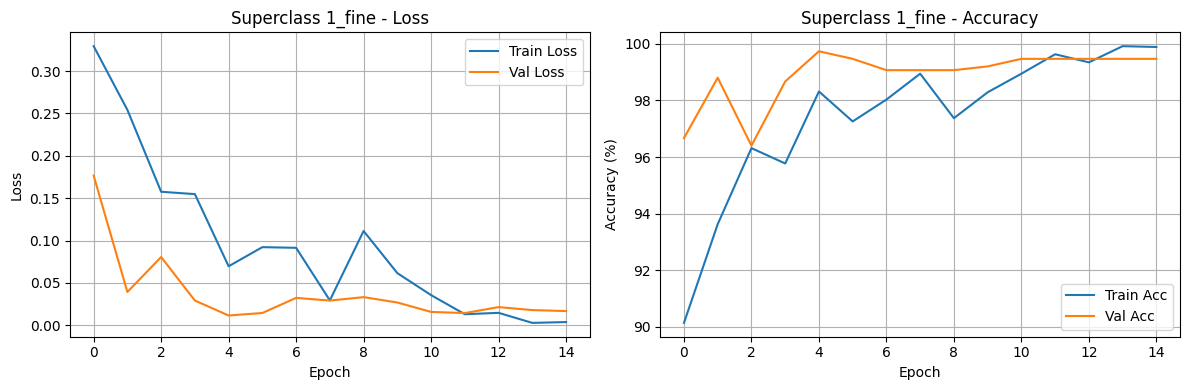


Evaluating fine-grained classifier for Superclass 1...
Fine-grained Accuracy: 0.9947
Fine-grained F1 Score: 0.9947


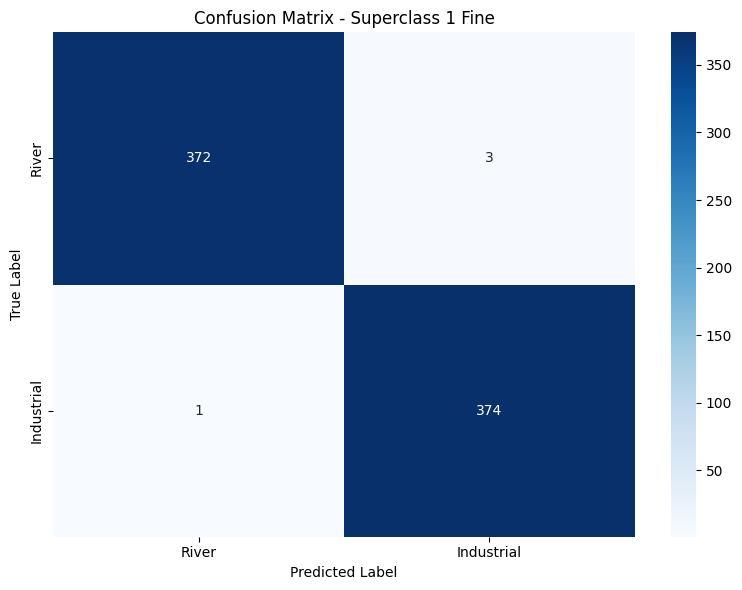

In [8]:
# CELL 4: Train Fine-grained Classifier for Superclass 1
print("\nCELL 4: Training Fine-grained Classifier for Superclass 1")
print("="*60)

superclass_name = 'Superclass 1'
superclass_idx = 1

classes = hierarchy[superclass_name]
if isinstance(classes, dict):
    num_classes = sum(len(subgroup) for subgroup in classes.values())
else:
    num_classes = len(classes)

print(f"Superclass {superclass_idx} has {num_classes} classes")

if num_classes > 1:
    fine_model, fine_history = hierarchical_classifier.train_fine_classifier(
        train_loader=train_loader,
        val_loader=val_loader,
        superclass_idx=superclass_idx,
        superclass_name=superclass_name,
        num_epochs=15,
        lr=0.001,
        model_save_path=f"models/fine_classifier_superclass_{superclass_idx}.pth"
    )
    if fine_model:
        hierarchical_classifier.fine_models[superclass_idx] = fine_model
else:
    print(f"Skipping fine-grained training for {superclass_name} - only one class")


CELL 4: Training Fine-grained Classifier for Superclass 1
Superclass 2 has 7 classes

TRAINING FINE-GRAINED CLASSIFIER FOR: Superclass 2
Number of fine classes: 7


Epoch 1/15 [Train]: 100%|██████████| 604/604 [00:59<00:00, 10.22it/s, Loss=1.5185, Acc=78.23%]


Epoch 1: Train Loss: 0.6650, Train Acc: 78.23% | Val Loss: 0.2810, Val Acc: 90.60%


Epoch 2/15 [Train]: 100%|██████████| 604/604 [00:57<00:00, 10.58it/s, Loss=0.5290, Acc=86.78%]


Epoch 2: Train Loss: 0.4139, Train Acc: 86.78% | Val Loss: 0.2690, Val Acc: 91.54%


Epoch 3/15 [Train]: 100%|██████████| 604/604 [00:57<00:00, 10.49it/s, Loss=0.2696, Acc=89.50%]


Epoch 3: Train Loss: 0.3138, Train Acc: 89.50% | Val Loss: 0.3040, Val Acc: 90.42%


Epoch 4/15 [Train]: 100%|██████████| 604/604 [00:57<00:00, 10.43it/s, Loss=0.3623, Acc=91.81%]


Epoch 4: Train Loss: 0.2493, Train Acc: 91.81% | Val Loss: 0.3297, Val Acc: 89.47%


Epoch 5/15 [Train]: 100%|██████████| 604/604 [00:56<00:00, 10.68it/s, Loss=0.2236, Acc=92.38%]


Epoch 5: Train Loss: 0.2371, Train Acc: 92.38% | Val Loss: 0.2588, Val Acc: 91.23%


Epoch 6/15 [Train]: 100%|██████████| 604/604 [00:57<00:00, 10.50it/s, Loss=0.2890, Acc=94.01%]


Epoch 6: Train Loss: 0.1884, Train Acc: 94.01% | Val Loss: 0.2655, Val Acc: 91.40%


Epoch 7/15 [Train]: 100%|██████████| 604/604 [00:57<00:00, 10.48it/s, Loss=0.0342, Acc=94.88%]


Epoch 7: Train Loss: 0.1526, Train Acc: 94.88% | Val Loss: 0.2465, Val Acc: 91.72%


Epoch 8/15 [Train]: 100%|██████████| 604/604 [00:56<00:00, 10.77it/s, Loss=0.0968, Acc=95.89%]


Epoch 8: Train Loss: 0.1292, Train Acc: 95.89% | Val Loss: 0.2521, Val Acc: 92.32%


Epoch 9/15 [Train]: 100%|██████████| 604/604 [00:56<00:00, 10.62it/s, Loss=0.5676, Acc=96.02%]


Epoch 9: Train Loss: 0.1238, Train Acc: 96.02% | Val Loss: 0.2589, Val Acc: 91.44%


Epoch 10/15 [Train]: 100%|██████████| 604/604 [00:57<00:00, 10.54it/s, Loss=0.1025, Acc=96.81%]


Epoch 10: Train Loss: 0.0953, Train Acc: 96.81% | Val Loss: 0.2534, Val Acc: 91.65%


Epoch 11/15 [Train]: 100%|██████████| 604/604 [00:56<00:00, 10.78it/s, Loss=0.0435, Acc=96.71%]


Epoch 11: Train Loss: 0.1028, Train Acc: 96.71% | Val Loss: 0.3058, Val Acc: 90.14%


Epoch 12/15 [Train]: 100%|██████████| 604/604 [00:57<00:00, 10.43it/s, Loss=0.0043, Acc=96.87%]


Epoch 12: Train Loss: 0.0971, Train Acc: 96.87% | Val Loss: 0.3674, Val Acc: 89.16%


Epoch 13/15 [Train]: 100%|██████████| 604/604 [00:57<00:00, 10.57it/s, Loss=0.2051, Acc=97.53%]


Epoch 13: Train Loss: 0.0784, Train Acc: 97.53% | Val Loss: 0.3309, Val Acc: 90.35%


Epoch 14/15 [Train]: 100%|██████████| 604/604 [00:56<00:00, 10.72it/s, Loss=0.1082, Acc=99.46%]


Epoch 14: Train Loss: 0.0190, Train Acc: 99.46% | Val Loss: 0.1941, Val Acc: 94.84%


Epoch 15/15 [Train]: 100%|██████████| 604/604 [00:56<00:00, 10.64it/s, Loss=0.0010, Acc=99.34%]


Epoch 15: Train Loss: 0.0194, Train Acc: 99.34% | Val Loss: 0.2340, Val Acc: 93.72%
Model saved to models/fine_classifier_superclass_2.pth


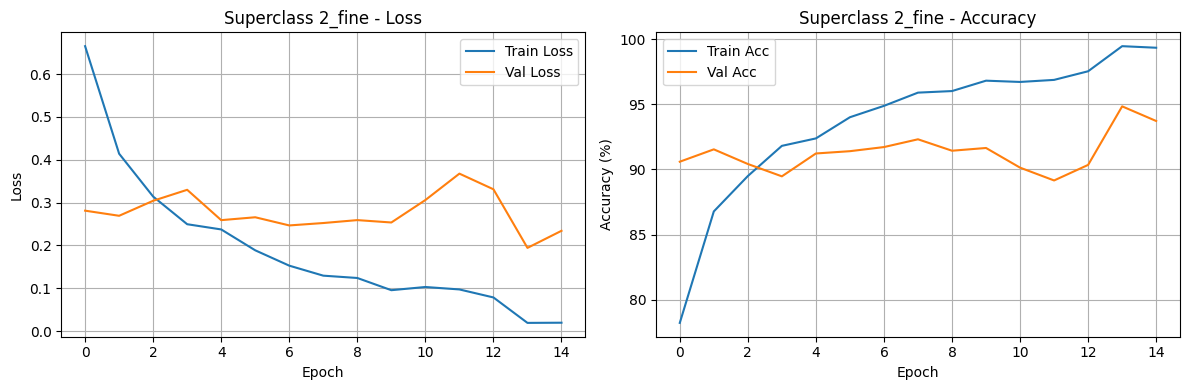


Evaluating fine-grained classifier for Superclass 2...
Fine-grained Accuracy: 0.9372
Fine-grained F1 Score: 0.9368


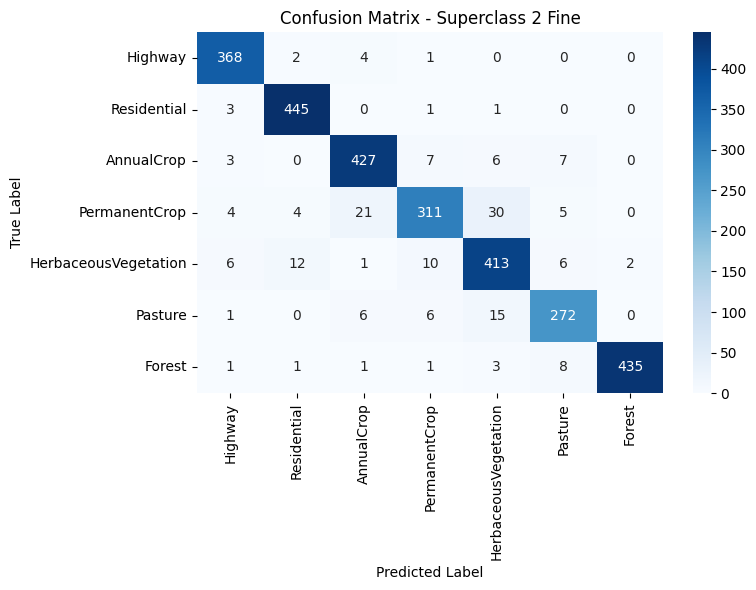

In [9]:
# CELL 4: Train Fine-grained Classifier for Superclass 1
print("\nCELL 4: Training Fine-grained Classifier for Superclass 1")
print("="*60)

superclass_name = 'Superclass 2'
superclass_idx = 2

classes = hierarchy[superclass_name]
if isinstance(classes, dict):
    num_classes = sum(len(subgroup) for subgroup in classes.values())
else:
    num_classes = len(classes)

print(f"Superclass {superclass_idx} has {num_classes} classes")

if num_classes > 1:
    fine_model, fine_history = hierarchical_classifier.train_fine_classifier(
        train_loader=train_loader,
        val_loader=val_loader,
        superclass_idx=superclass_idx,
        superclass_name=superclass_name,
        num_epochs=15,
        lr=0.001,
        model_save_path=f"models/fine_classifier_superclass_{superclass_idx}.pth"
    )
    if fine_model:
        hierarchical_classifier.fine_models[superclass_idx] = fine_model
else:
    print(f"Skipping fine-grained training for {superclass_name} - only one class")


CELL 6: Hierarchical Evaluation on Test Set
Evaluating hierarchical classification on test set...


Testing: 100%|██████████| 130/130 [00:30<00:00,  4.29it/s]



Overall Hierarchical Accuracy: 0.9300
Superclass Accuracy: 0.9725

Classification Report (Overall):
                      precision    recall  f1-score   support

          AnnualCrop     0.9188    0.9556    0.9368       450
              Forest     0.9707    0.9556    0.9630       450
HerbaceousVegetation     0.8542    0.9111    0.8817       450
             Highway     0.9229    0.9573    0.9398       375
          Industrial     0.8725    0.9307    0.9006       375
             Pasture     0.9388    0.8700    0.9031       300
       PermanentCrop     0.9024    0.8133    0.8555       375
         Residential     0.9562    0.9222    0.9389       450
               River     0.9781    0.9547    0.9663       375
             SeaLake     0.9798    0.9870    0.9834       540

            accuracy                         0.9300      4140
           macro avg     0.9294    0.9257    0.9269      4140
        weighted avg     0.9309    0.9300    0.9298      4140


Hierarchical Evaluation Met

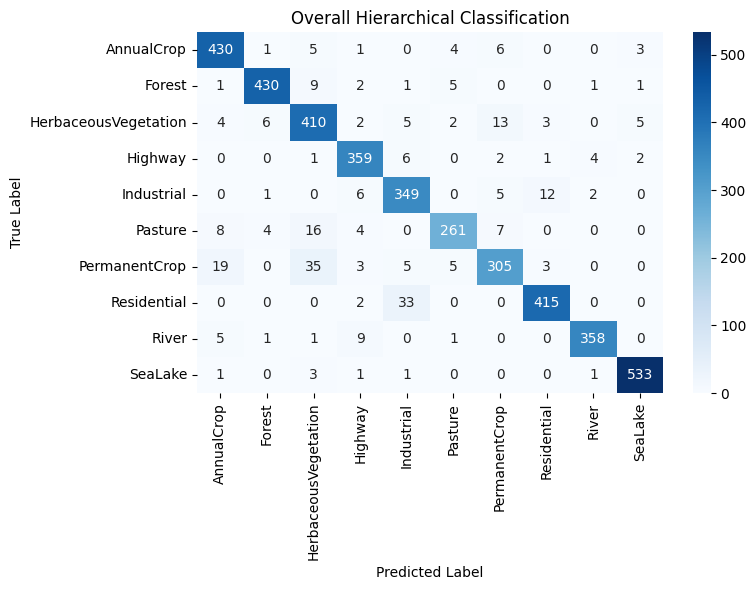


Hierarchical classification evaluation complete!
Results saved to hierarchical_results.json


In [11]:
# CELL 6: Hierarchical Evaluation on Test Set
print("\nCELL 6: Hierarchical Evaluation on Test Set")
print("="*60)

def hierarchical_predict(hierarchical_classifier, superclass_model, image):
    """Make hierarchical prediction"""
    # First predict superclass
    with torch.no_grad():
        superclass_output = superclass_model(image.unsqueeze(0))
        superclass_pred = superclass_output.argmax().item()

    # Then predict fine class if available
    if superclass_pred in hierarchical_classifier.fine_models:
        fine_model = hierarchical_classifier.fine_models[superclass_pred]
        with torch.no_grad():
            fine_output = fine_model(image.unsqueeze(0))
            fine_pred = fine_output.argmax().item()

        # Map back to original class
        superclass_name = list(hierarchical_classifier.hierarchy.keys())[superclass_pred]
        classes = hierarchical_classifier.hierarchy[superclass_name]

        if isinstance(classes, dict):
            all_classes = []
            for subgroup in classes.values():
                all_classes.extend(subgroup)
            fine_class_name = all_classes[fine_pred]
        else:
            fine_class_name = classes[fine_pred]

        original_class_idx = CLASS_NAMES.index(fine_class_name)
    else:
        # Direct mapping for single-class superclasses
        superclass_name = list(hierarchical_classifier.hierarchy.keys())[superclass_pred]
        classes = hierarchical_classifier.hierarchy[superclass_name]

        if isinstance(classes, dict):
            all_classes = []
            for subgroup in classes.values():
                all_classes.extend(subgroup)
            original_class_name = all_classes[0]
        else:
            original_class_name = classes[0]
        original_class_idx = CLASS_NAMES.index(original_class_name)

    return original_class_idx, superclass_pred

# Evaluate on test set
print("Evaluating hierarchical classification on test set...")

all_predictions = []
all_original_labels = []
all_superclass_predictions = []
all_superclass_true = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images = images.to(device)

        for i in range(len(images)):
            image = images[i]
            true_label = labels[i].item()

            # Get true superclass
            true_superclass = hierarchical_classifier.get_superclass_label(true_label)

            # Make hierarchical prediction
            pred_label, pred_superclass = hierarchical_predict(
                hierarchical_classifier,
                superclass_model,
                image
            )

            all_predictions.append(pred_label)
            all_original_labels.append(true_label)
            all_superclass_predictions.append(pred_superclass)
            all_superclass_true.append(true_superclass)

# Calculate overall accuracy
overall_accuracy = accuracy_score(all_original_labels, all_predictions)
print(f"\nOverall Hierarchical Accuracy: {overall_accuracy:.4f}")

# Calculate superclass accuracy
superclass_accuracy = accuracy_score(all_superclass_true, all_superclass_predictions)
print(f"Superclass Accuracy: {superclass_accuracy:.4f}")

# Classification report
print("\nClassification Report (Overall):")
print(classification_report(all_original_labels, all_predictions,
                          target_names=CLASS_NAMES, digits=4))

# Hierarchical evaluation metrics
print("\nHierarchical Evaluation Metrics:")
print("-" * 40)

# Calculate hierarchical precision and recall
hierarchical_correct = 0
superclass_correct = 0
total_samples = len(all_original_labels)

for i in range(total_samples):
    true_label = all_original_labels[i]
    pred_label = all_predictions[i]
    true_superclass = all_superclass_true[i]
    pred_superclass = all_superclass_predictions[i]

    # Count superclass correct
    if true_superclass == pred_superclass:
        superclass_correct += 1

        # Count hierarchical correct (both superclass and fine class)
        if true_label == pred_label:
            hierarchical_correct += 1

hierarchical_accuracy = hierarchical_correct / total_samples
print(f"Hierarchical Accuracy (both levels correct): {hierarchical_accuracy:.4f}")
print(f"Superclass-only Accuracy: {superclass_correct/total_samples:.4f}")

# Per-superclass performance
print("\nPer-Superclass Performance:")
print("-" * 40)

for superclass_name, classes in hierarchy.items():
    superclass_idx = list(hierarchy.keys()).index(superclass_name)

    # Get indices for this superclass
    indices = [i for i, sc in enumerate(all_superclass_true) if sc == superclass_idx]

    if indices:
        superclass_acc = np.mean([all_superclass_predictions[i] == superclass_idx
                                for i in indices])

        # Fine accuracy for this superclass
        if isinstance(classes, dict):
            num_fine_classes = sum(len(subgroup) for subgroup in classes.values())
        else:
            num_fine_classes = len(classes)

        if num_fine_classes > 1:
            fine_correct = 0
            fine_total = 0
            for i in indices:
                if all_superclass_predictions[i] == superclass_idx:
                    fine_total += 1
                    if all_predictions[i] == all_original_labels[i]:
                        fine_correct += 1

            if fine_total > 0:
                fine_acc = fine_correct / fine_total
                print(f"{superclass_name}: Superclass Acc: {superclass_acc:.4f}, "
                      f"Fine Acc: {fine_acc:.4f} "
                      f"({fine_total} samples)")
            else:
                print(f"{superclass_name}: Superclass Acc: {superclass_acc:.4f}, "
                      f"No fine predictions")
        else:
            print(f"{superclass_name}: Superclass Acc: {superclass_acc:.4f}, "
                  f"Single class - no fine classifier")
    else:
        print(f"{superclass_name}: No samples in test set")

# Final confusion matrix
print("\nFinal Overall Confusion Matrix:")
hierarchical_classifier.plot_confusion_matrix(
    all_original_labels, all_predictions,
    range(len(CLASS_NAMES)),
    "Overall Hierarchical Classification",
    class_names=CLASS_NAMES
)

print("\nHierarchical classification evaluation complete!")
print("="*60)

# Save evaluation results
results = {
    'hierarchical_plan': HIERARCHICAL_PLAN,
    'overall_accuracy': overall_accuracy,
    'superclass_accuracy': superclass_accuracy,
    'hierarchical_accuracy': hierarchical_accuracy,
    'per_class_accuracy': dict(zip(CLASS_NAMES,
        [np.mean([all_predictions[i] == j for i, true_label in enumerate(all_original_labels)
                 if true_label == j]) if any(true_label == j for true_label in all_original_labels) else 0
         for j in range(len(CLASS_NAMES))]))
}

with open('hierarchical_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print("Results saved to hierarchical_results.json")